# Method 5 - Best Ideas High Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

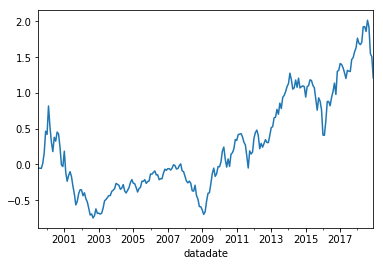

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.464751
2000-12-31   -0.337000
2001-12-31   -0.333380
2002-12-31   -0.512028
2003-12-31    1.096074
2004-12-31    0.191095
2005-12-31   -0.024294
2006-12-31    0.192162
2007-12-31   -0.019087
2008-12-31   -0.545081
2009-12-31    1.369018
2010-12-31    0.391579
2011-12-31   -0.129462
2012-12-31    0.196787
2013-12-31    0.484975
2014-12-31   -0.000119
2015-12-31   -0.154786
2016-12-31    0.313247
2017-12-31    0.134394
2018-12-31   -0.160005
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     346.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.16e-96
Time:                        05:31:10   Log-Likelihood:                 429.78
No. Observations:                 234   AIC:                            -849.6
Df Residuals:                     229   BIC:                            -832.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.003      2.086      0.038       0.000       0.011
mktrf          1.3271      0.073     18.256      0.000       1.184       1.470
me             0.5941      0.085      7.026      0.000       0.427       0.761
ia            -0.0264      0.129     -0.205      0.838      -0.280       0.227
roe           -1.2576      0.110    -11.432      0.000      -1.474      -1.041
==============================================================================
Omnibus:                      116.813   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1120.416
Skew:                           1.709   Prob(JB):                    5.07e-244
Kurtosis:                      13.160   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     163.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.94e-66
Time:                        05:31:10   Log-Likelihood:                 429.78
No. Observations:                 234   AIC:                            -849.6
Df Residuals:                     229   BIC:                            -832.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.003      2.042      0.041       0.000       0.011
mktrf          1.3271      0.130     10.202      0.000       1.072       1.582
me             0.5941      0.102      5.798      0.000       0.393       0.795
ia            -0.0264      0.160     -0.165      0.869      -0.339       0.286
roe           -1.2576      0.177     -7.105      0.000      -1.605      -0.911
==============================================================================
Omnibus:                      116.813   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1120.416
Skew:                           1.709   Prob(JB):                    5.07e-244
Kurtosis:                      13.160   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     203.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.44e-74
Time:                        05:31:10   Log-Likelihood:                 429.78
No. Observations:                 234   AIC:                            -849.6
Df Residuals:                     229   BIC:                            -832.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.003      1.925      0.054   -9.97e-05       0.011
mktrf          1.3271      0.129     10.265      0.000       1.074       1.580
me             0.5941      0.115      5.182      0.000       0.369       0.819
ia            -0.0264      0.138     -0.191      0.848      -0.296       0.244
roe           -1.2576      0.191     -6.579      0.000      -1.632      -0.883
==============================================================================
Omnibus:                      116.813   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1120.416
Skew:                           1.709   Prob(JB):                    5.07e-244
Kurtosis:                      13.160   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     229.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.49e-87
Time:                        05:31:10   Log-Likelihood:                 411.77
No. Observations:                 234   AIC:                            -811.5
Df Residuals:                     228   BIC:                            -790.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.544      0.124      -0.001       0.010
mktrf          1.4619      0.079     18.543      0.000       1.307       1.617
smb            0.6117      0.104      5.880      0.000       0.407       0.817
hml            0.2132      0.123      1.738      0.084      -0.029       0.455
rmw           -1.1305      0.139     -8.152      0.000      -1.404      -0.857
cma            0.0017      0.176      0.009      0.993      -0.346       0.349
==============================================================================
Omnibus:                      122.206   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              813.336
Skew:                           1.969   Prob(JB):                    2.43e-177
Kurtosis:                      11.241   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     130.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.75e-65
Time:                        05:31:10   Log-Likelihood:                 411.77
No. Observations:                 234   AIC:                            -811.5
Df Residuals:                     228   BIC:                            -790.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.534      0.125      -0.001       0.010
mktrf          1.4619      0.096     15.269      0.000       1.274       1.650
smb            0.6117      0.105      5.819      0.000       0.406       0.818
hml            0.2132      0.170      1.257      0.209      -0.119       0.545
rmw           -1.1305      0.187     -6.043      0.000      -1.497      -0.764
cma            0.0017      0.229      0.007      0.994      -0.447       0.450
==============================================================================
Omnibus:                      122.206   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              813.336
Skew:                           1.969   Prob(JB):                    2.43e-177
Kurtosis:                      11.241   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     162.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.68e-73
Time:                        05:31:10   Log-Likelihood:                 411.77
No. Observations:                 234   AIC:                            -811.5
Df Residuals:                     228   BIC:                            -790.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.402      0.161      -0.002       0.011
mktrf          1.4619      0.084     17.372      0.000       1.297       1.627
smb            0.6117      0.114      5.355      0.000       0.388       0.836
hml            0.2132      0.130      1.641      0.101      -0.041       0.468
rmw           -1.1305      0.198     -5.706      0.000      -1.519      -0.742
cma            0.0017      0.200      0.008      0.993      -0.391       0.395
==============================================================================
Omnibus:                      122.206   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              813.336
Skew:                           1.969   Prob(JB):                    2.43e-177
Kurtosis:                      11.241   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     275.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.60e-86
Time:                        05:31:10   Log-Likelihood:                 407.39
No. Observations:                 234   AIC:                            -804.8
Df Residuals:                     229   BIC:                            -787.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.003      0.416      0.678      -0.004       0.007
mktrf          1.5408      0.074     20.921      0.000       1.396       1.686
smb            1.1299      0.092     12.290      0.000       0.949       1.311
hml           -0.0775      0.091     -0.849      0.397      -0.257       0.102
umd           -0.4362      0.060     -7.280      0.000      -0.554      -0.318
==============================================================================
Omnibus:                       79.132   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.341
Skew:                           1.257   Prob(JB):                     1.56e-83
Kurtosis:                       8.726   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     88.92
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.73e-45
Time:                        05:31:10   Log-Likelihood:                 407.39
No. Observations:                 234   AIC:                            -804.8
Df Residuals:                     229   BIC:                            -787.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.003      0.439      0.661      -0.004       0.006
mktrf          1.5408      0.117     13.163      0.000       1.311       1.770
smb            1.1299      0.128      8.855      0.000       0.880       1.380
hml           -0.0775      0.117     -0.664      0.506      -0.306       0.151
umd           -0.4362      0.104     -4.188      0.000      -0.640      -0.232
==============================================================================
Omnibus:                       79.132   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.341
Skew:                           1.257   Prob(JB):                     1.56e-83
Kurtosis:                       8.726   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     97.25
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.14e-48
Time:                        05:31:10   Log-Likelihood:                 407.39
No. Observations:                 234   AIC:                            -804.8
Df Residuals:                     229   BIC:                            -787.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.003      0.434      0.664      -0.004       0.007
mktrf          1.5408      0.115     13.388      0.000       1.315       1.766
smb            1.1299      0.122      9.243      0.000       0.890       1.369
hml           -0.0775      0.104     -0.747      0.455      -0.281       0.126
umd           -0.4362      0.104     -4.202      0.000      -0.640      -0.233
==============================================================================
Omnibus:                       79.132   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.341
Skew:                           1.257   Prob(JB):                     1.56e-83
Kurtosis:                       8.726   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     162.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.65e-46
Time:                        05:31:10   Log-Likelihood:                 196.97
No. Observations:                 120   AIC:                            -383.9
Df Residuals:                     115   BIC:                            -370.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.005      1.949      0.054      -0.000       0.018
mktrf          1.2475      0.123     10.109      0.000       1.003       1.492
me             0.5213      0.122      4.277      0.000       0.280       0.763
ia            -0.1186      0.191     -0.621      0.536      -0.497       0.259
roe           -1.3244      0.169     -7.840      0.000      -1.659      -0.990
==============================================================================
Omnibus:                       51.383   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.977
Skew:                           1.389   Prob(JB):                     1.56e-51
Kurtosis:                       9.251   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     130.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.72e-42
Time:                        05:31:10   Log-Likelihood:                 196.97
No. Observations:                 120   AIC:                            -383.9
Df Residuals:                     115   BIC:                            -370.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.004      2.239      0.025       0.001       0.017
mktrf          1.2475      0.198      6.296      0.000       0.859       1.636
me             0.5213      0.136      3.820      0.000       0.254       0.789
ia            -0.1186      0.219     -0.542      0.588      -0.547       0.310
roe           -1.3244      0.231     -5.725      0.000      -1.778      -0.871
==============================================================================
Omnibus:                       51.383   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.977
Skew:                           1.389   Prob(JB):                     1.56e-51
Kurtosis:                       9.251   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     163.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.57e-46
Time:                        05:31:10   Log-Likelihood:                 196.97
No. Observations:                 120   AIC:                            -383.9
Df Residuals:                     115   BIC:                            -370.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.004      2.263      0.024       0.001       0.017
mktrf          1.2475      0.197      6.321      0.000       0.861       1.634
me             0.5213      0.150      3.484      0.000       0.228       0.815
ia            -0.1186      0.185     -0.640      0.522      -0.482       0.245
roe           -1.3244      0.259     -5.104      0.000      -1.833      -0.816
==============================================================================
Omnibus:                       51.383   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.977
Skew:                           1.389   Prob(JB):                     1.56e-51
Kurtosis:                       9.251   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.37e-41
Time:                        05:31:10   Log-Likelihood:                 188.26
No. Observations:                 120   AIC:                            -364.5
Df Residuals:                     114   BIC:                            -347.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.005      1.917      0.058      -0.000       0.020
mktrf          1.5090      0.141     10.737      0.000       1.231       1.787
smb            0.5541      0.159      3.481      0.001       0.239       0.869
hml            0.0993      0.195      0.509      0.612      -0.287       0.486
rmw           -1.0762      0.230     -4.679      0.000      -1.532      -0.621
cma            0.0306      0.252      0.122      0.903      -0.469       0.530
==============================================================================
Omnibus:                       65.540   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.201
Skew:                           1.943   Prob(JB):                     9.51e-59
Kurtosis:                       9.192   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     101.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.41e-40
Time:                        05:31:10   Log-Likelihood:                 188.26
No. Observations:                 120   AIC:                            -364.5
Df Residuals:                     114   BIC:                            -347.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.004      2.377      0.017       0.002       0.018
mktrf          1.5090      0.170      8.856      0.000       1.175       1.843
smb            0.5541      0.156      3.559      0.000       0.249       0.859
hml            0.0993      0.183      0.543      0.587      -0.259       0.458
rmw           -1.0762      0.265     -4.057      0.000      -1.596      -0.556
cma            0.0306      0.258      0.119      0.905      -0.475       0.536
==============================================================================
Omnibus:                       65.540   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.201
Skew:                           1.943   Prob(JB):                     9.51e-59
Kurtosis:                       9.192   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     118.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.98e-43
Time:                        05:31:10   Log-Likelihood:                 188.26
No. Observations:                 120   AIC:                            -364.5
Df Residuals:                     114   BIC:                            -347.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.004      2.306      0.021       0.001       0.018
mktrf          1.5090      0.139     10.861      0.000       1.237       1.781
smb            0.5541      0.161      3.449      0.001       0.239       0.869
hml            0.0993      0.168      0.591      0.555      -0.230       0.429
rmw           -1.0762      0.287     -3.747      0.000      -1.639      -0.513
cma            0.0306      0.219      0.140      0.888      -0.398       0.459
==============================================================================
Omnibus:                       65.540   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.201
Skew:                           1.943   Prob(JB):                     9.51e-59
Kurtosis:                       9.192   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     140.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.85e-43
Time:                        05:31:10   Log-Likelihood:                 189.67
No. Observations:                 120   AIC:                            -369.3
Df Residuals:                     115   BIC:                            -355.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.005      1.024      0.308      -0.005       0.014
mktrf          1.5935      0.116     13.791      0.000       1.365       1.822
smb            1.1065      0.132      8.411      0.000       0.846       1.367
hml           -0.2102      0.132     -1.596      0.113      -0.471       0.051
umd           -0.4185      0.081     -5.152      0.000      -0.579      -0.258
==============================================================================
Omnibus:                       41.895   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.264
Skew:                           1.193   Prob(JB):                     2.86e-32
Kurtosis:                       7.833   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     57.38
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.57e-26
Time:                        05:31:10   Log-Likelihood:                 189.67
No. Observations:                 120   AIC:                            -369.3
Df Residuals:                     115   BIC:                            -355.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.004      1.256      0.209      -0.003       0.013
mktrf          1.5935      0.186      8.590      0.000       1.230       1.957
smb            1.1065      0.144      7.694      0.000       0.825       1.388
hml           -0.2102      0.147     -1.435      0.151      -0.497       0.077
umd           -0.4185      0.110     -3.788      0.000      -0.635      -0.202
==============================================================================
Omnibus:                       41.895   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.264
Skew:                           1.193   Prob(JB):                     2.86e-32
Kurtosis:                       7.833   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     68.98
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.16e-29
Time:                        05:31:10   Log-Likelihood:                 189.67
No. Observations:                 120   AIC:                            -369.3
Df Residuals:                     115   BIC:                            -355.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.004      1.315      0.189      -0.002       0.012
mktrf          1.5935      0.186      8.556      0.000       1.228       1.959
smb            1.1065      0.133      8.310      0.000       0.846       1.367
hml           -0.2102      0.138     -1.526      0.127      -0.480       0.060
umd           -0.4185      0.110     -3.789      0.000      -0.635      -0.202
==============================================================================
Omnibus:                       41.895   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.264
Skew:                           1.193   Prob(JB):                     2.86e-32
Kurtosis:                       7.833   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     214.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.11e-50
Time:                        05:31:10   Log-Likelihood:                 253.49
No. Observations:                 114   AIC:                            -497.0
Df Residuals:                     109   BIC:                            -483.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.759      0.450      -0.003       0.007
mktrf          1.4009      0.079     17.794      0.000       1.245       1.557
me             0.7055      0.122      5.804      0.000       0.465       0.946
ia             0.1229      0.169      0.729      0.468      -0.211       0.457
roe           -1.1885      0.148     -8.022      0.000      -1.482      -0.895
==============================================================================
Omnibus:                       21.161   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.669
Skew:                           0.838   Prob(JB):                     2.96e-08
Kurtosis:                       5.119   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     135.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.48e-41
Time:                        05:31:10   Log-Likelihood:                 253.49
No. Observations:                 114   AIC:                            -497.0
Df Residuals:                     109   BIC:                            -483.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.910      0.363      -0.002       0.006
mktrf          1.4009      0.101     13.915      0.000       1.204       1.598
me             0.7055      0.144      4.892      0.000       0.423       0.988
ia             0.1229      0.177      0.696      0.487      -0.223       0.469
roe           -1.1885      0.227     -5.230      0.000      -1.634      -0.743
==============================================================================
Omnibus:                       21.161   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.669
Skew:                           0.838   Prob(JB):                     2.96e-08
Kurtosis:                       5.119   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     158.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.81e-44
Time:                        05:31:10   Log-Likelihood:                 253.49
No. Observations:                 114   AIC:                            -497.0
Df Residuals:                     109   BIC:                            -483.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.983      0.326      -0.002       0.006
mktrf          1.4009      0.098     14.347      0.000       1.210       1.592
me             0.7055      0.170      4.138      0.000       0.371       1.040
ia             0.1229      0.179      0.688      0.491      -0.227       0.473
roe           -1.1885      0.221     -5.373      0.000      -1.622      -0.755
==============================================================================
Omnibus:                       21.161   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.669
Skew:                           0.838   Prob(JB):                     2.96e-08
Kurtosis:                       5.119   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     142.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.08e-46
Time:                        05:31:10   Log-Likelihood:                 244.54
No. Observations:                 114   AIC:                            -477.1
Df Residuals:                     108   BIC:                            -460.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.003     -0.084      0.933      -0.006       0.006
mktrf          1.4422      0.082     17.675      0.000       1.280       1.604
smb            0.6848      0.132      5.169      0.000       0.422       0.947
hml            0.3963      0.169      2.346      0.021       0.061       0.731
rmw           -1.0728      0.207     -5.186      0.000      -1.483      -0.663
cma           -0.0478      0.263     -0.182      0.856      -0.568       0.473
==============================================================================
Omnibus:                        9.946   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               13.307
Skew:                           0.455   Prob(JB):                      0.00129
Kurtosis:                       4.405   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     106.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.10e-40
Time:                        05:31:10   Log-Likelihood:                 244.54
No. Observations:                 114   AIC:                            -477.1
Df Residuals:                     108   BIC:                            -460.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.003     -0.079      0.937      -0.006       0.006
mktrf          1.4422      0.082     17.528      0.000       1.281       1.603
smb            0.6848      0.132      5.177      0.000       0.426       0.944
hml            0.3963      0.177      2.245      0.025       0.050       0.742
rmw           -1.0728      0.232     -4.618      0.000      -1.528      -0.618
cma           -0.0478      0.224     -0.214      0.831      -0.486       0.391
==============================================================================
Omnibus:                        9.946   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               13.307
Skew:                           0.455   Prob(JB):                      0.00129
Kurtosis:                       4.405   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     130.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.14e-44
Time:                        05:31:10   Log-Likelihood:                 244.54
No. Observations:                 114   AIC:                            -477.1
Df Residuals:                     108   BIC:                            -460.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.003     -0.083      0.934      -0.006       0.006
mktrf          1.4422      0.081     17.701      0.000       1.283       1.602
smb            0.6848      0.148      4.630      0.000       0.395       0.975
hml            0.3963      0.152      2.607      0.009       0.098       0.694
rmw           -1.0728      0.193     -5.554      0.000      -1.451      -0.694
cma           -0.0478      0.230     -0.208      0.835      -0.498       0.402
==============================================================================
Omnibus:                        9.946   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               13.307
Skew:                           0.455   Prob(JB):                      0.00129
Kurtosis:                       4.405   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     154.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.58e-44
Time:                        05:31:10   Log-Likelihood:                 237.13
No. Observations:                 114   AIC:                            -464.3
Df Residuals:                     109   BIC:                            -450.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.003     -0.357      0.722      -0.007       0.005
mktrf          1.4764      0.086     17.143      0.000       1.306       1.647
smb            0.9375      0.134      6.981      0.000       0.671       1.204
hml            0.3823      0.138      2.764      0.007       0.108       0.656
umd           -0.3691      0.104     -3.538      0.001      -0.576      -0.162
==============================================================================
Omnibus:                       15.520   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.712
Skew:                           0.626   Prob(JB):                     4.30e-06
Kurtosis:                       4.907   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     168.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.59e-46
Time:                        05:31:10   Log-Likelihood:                 237.13
No. Observations:                 114   AIC:                            -464.3
Df Residuals:                     109   BIC:                            -450.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.002     -0.444      0.657      -0.006       0.004
mktrf          1.4764      0.088     16.794      0.000       1.304       1.649
smb            0.9375      0.146      6.435      0.000       0.652       1.223
hml            0.3823      0.182      2.098      0.036       0.025       0.739
umd           -0.3691      0.117     -3.159      0.002      -0.598      -0.140
==============================================================================
Omnibus:                       15.520   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.712
Skew:                           0.626   Prob(JB):                     4.30e-06
Kurtosis:                       4.907   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     256.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.69e-54
Time:                        05:31:10   Log-Likelihood:                 237.13
No. Observations:                 114   AIC:                            -464.3
Df Residuals:                     109   BIC:                            -450.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.002     -0.471      0.638      -0.006       0.003
mktrf          1.4764      0.084     17.657      0.000       1.313       1.640
smb            0.9375      0.135      6.954      0.000       0.673       1.202
hml            0.3823      0.182      2.102      0.036       0.026       0.739
umd           -0.3691      0.114     -3.224      0.001      -0.594      -0.145
==============================================================================
Omnibus:                       15.520   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.712
Skew:                           0.626   Prob(JB):                     4.30e-06
Kurtosis:                       4.907   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""